In [4]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
from scipy.stats import gmean
import cv2
import matplotlib.pyplot as plt

# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [5]:
image= "/home/casper/Documents/Aardwetenschappen/MSc Thesis/Photo/08_07_22/Location_1/Loc_1_6.jpg"
resolution = 0.0515957446808511
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)
maxscale= width*resolution / 8

x= 0
verbose = 1

im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

filter=False

if filter:
    sigma_est = estimate_sigma(im, multichannel=False, average_sigmas=True)
    region = denoise_wavelet(im, multichannel=False, rescale_sigma=True,
                                method='VisuShrink', mode='soft', sigma=sigma_est*2)
else:
    region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape


Testing

In [6]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1), np.maximum(nx,ny)/(width*resolution / .9), 1),  'morl', .5) #cmor10-1
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_1 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_1-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_1, np.mean(M), srt/2)
p = np.hstack([p])
scales_1 = np.hstack([scales_1])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_1 = (p*scales_1**x) / np.sum(p*scales_1**x) #volume-by-weight proportion

In [7]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 1), np.maximum(nx,ny)/(width*resolution / 3.9), 1),  'morl', .5) #cmor10-1.5
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_2 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_2-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_2, np.mean(M), srt/2)
p = np.hstack([p])
scales_2 = np.hstack([scales_2])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_2 = (p*scales_2**x) / np.sum(p*scales_2**x) #volume-by-weight proportion


In [8]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 4), np.maximum(nx,ny)/(width*resolution / 20), 1),  'morl', .5) #cmor10-1.9
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_3 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_3-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_3, np.mean(M), srt/2)
p = np.hstack([p])
scales_3 = np.hstack([scales_3])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_3 = (p*scales_3**x) / np.sum(p*scales_3**x) #volume-by-weight proportion

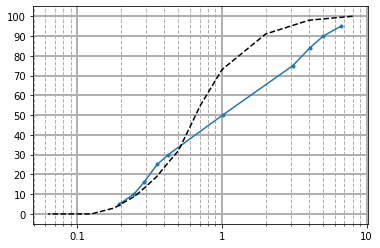

In [9]:
r_v_T = np.concatenate((r_v_1, r_v_2, r_v_3))
r_v_T = r_v_T / 3
scales_T = np.concatenate((scales_1, scales_2, scales_3))

pd_T = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_T))), np.hstack((0,scales_T)) ) * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_data_1 = [100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]

percentiles = [5, 10, 16, 25, 30, 50, 75, 84, 90, 95] 

dgs_data = [0.181454604, 0.292283726, 0.411418319, 0.580388498, 0.673668774, 1.076488632, 1.811835148, 2.327583741, 2.937335338, 3.749554738]

plt.plot(pd_T, percentiles, marker='.')
plt.plot(sieve_open, sieve_data_1, ls='--', color='black')


plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [10]:
for i in range(len(pd_T)):
    print(pd_T[i])

0.19516218527846824
0.24601185290531566
0.28887428160813566
0.3557229017142519
0.4258430723026433
1.0101356431358064
3.085682750099111
4.048827423127145
5.0172647699908826
6.651598080001455


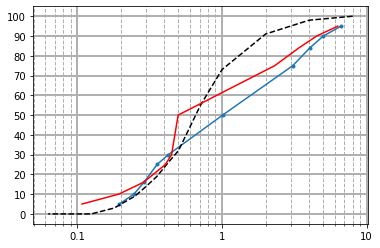

In [11]:
test = [0.107766565, 0.193308373, 0.28680506, 0.406366081, 0.448098974, 0.497635721, 2.314262063, 3.401015035, 4.515538293, 6.319018176]
# test = [0.107766565, 0.193308373, 0.28680506, 0.406366081, 0.448098974, 0.499496023, 0.670079198, 0.730375774, 0.765941864,	0.78601531]
# test = [0.107766565, 0.193308373, 0.28680506, 0.406366081, 0.448098974, 0.499949579, 0.741596635, 0.828334964, 0.885600472,	0.932168333] 
plt.plot(pd_T, percentiles, marker='.')
plt.plot(sieve_open, sieve_data_1, ls='--', color='black')
plt.plot(test, percentiles, color='red')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [3]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 0.1), np.maximum(nx,ny)/(width*resolution / 8), 1),  'morl', .5) #cmor10-1.9
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_3 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_3-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_3, np.mean(M), srt/2)
p = np.hstack([p])
scales_3 = np.hstack([scales_3])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_3 = (p*scales_3**x) / np.sum(p*scales_3**x) #volume-by-weight proportion

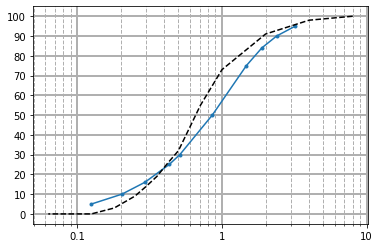

In [8]:
r_v_T = r_v_3

scales_T = scales_3

pd_T = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_T))), np.hstack((0,scales_T)) * resolution) 
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_data_1 = [100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]

percentiles = [5, 10, 16, 25, 30, 50, 75, 84, 90, 95] 


plt.plot(pd_T, percentiles, marker='.')
plt.plot(sieve_open, sieve_data_1, ls='--', color='black')


plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [5]:
print(np.hstack((0,np.cumsum(r_v_T))))

[0.         0.01562693 0.03179152 0.04990819 0.06959718 0.09001384
 0.11121442 0.13243781 0.15383145 0.17495742 0.19597761 0.21658455
 0.23686083 0.25700068 0.27693521 0.29670776 0.31622796 0.33558281
 0.35477296 0.37377619 0.39258464 0.41103383 0.42931179 0.44725343
 0.46489074 0.48221313 0.49914711 0.51573319 0.53197845 0.54782008
 0.56328236 0.57836684 0.59308122 0.60732812 0.621161   0.63456837
 0.64756407 0.66012137 0.67225772 0.68397649 0.69528518 0.70617803
 0.71667177 0.72678399 0.73652409 0.74586701 0.75484274 0.76346316
 0.77172959 0.77965488 0.78725388 0.79453691 0.80151238 0.80819728
 0.81459225 0.82071972 0.82658464 0.8322019  0.83758556 0.84274153
 0.84768086 0.85243247 0.85698184 0.86133523 0.86550498 0.86950401
 0.87336077 0.87706753 0.88063212 0.88406559 0.88737238 0.89055744
 0.8936304  0.89659189 0.89945275 0.90221545 0.9048852  0.90746831
 0.90996627 0.91238258 0.91472328 0.91699133 0.91918376 0.92131271
 0.92338017 0.92538632 0.92733187 0.92922289 0.93106014 0.9328

In [30]:
pd_Test = np.interp([8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063], np.hstack((0,scales_T)) * resolution,np.hstack((0,np.cumsum(r_v_T)))) 
print(pd_Test)

[1.         0.97749458 0.85720625 0.57167991 0.41876899 0.2929367
 0.24586666 0.20097533 0.16461223 0.13107033 0.08452028 0.04988484
 0.016371  ]


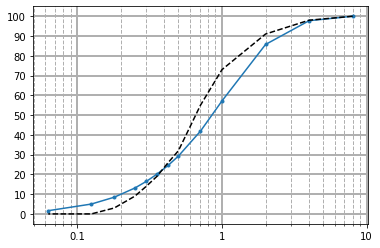

In [29]:
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_data_1 = [100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]

# pd_Test = pd_Test[::]
pd_Test = pd_Test*100
percentiles = [5, 10, 16, 25, 30, 50, 75, 84, 90, 95] 


plt.plot(sieve_open, pd_Test, marker='.')
plt.plot(sieve_open, sieve_data_1, ls='--', color='black')


plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

/tmp/ipykernel_2466/2900200950.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.scatter(sieve_open, (result/sieve_data_1))


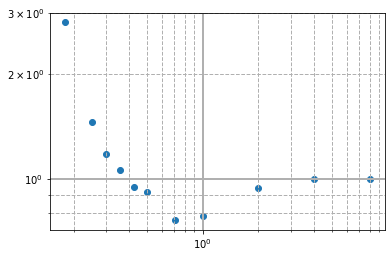

In [6]:
result = np.array([100, 97.749458, 85.720625, 57.167991, 41.876899, 29.29367, 24.586666, 20.097533, 16.461223, 13.107033, 8.452028, 4.988484, 1.6371])
sieve_open = np.array([8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063])
sieve_data_1 = np.array([100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0])

plt.scatter(sieve_open, (result/sieve_data_1))

plt.xscale("log")
plt.yscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.show()

In [7]:
print( np.hstack((0,scales_T))* resolution)

[0.         0.06153846 0.09328969 0.12504092 0.15679214 0.18854337
 0.2202946  0.25204583 0.28379705 0.31554828 0.34729951 0.37905074
 0.41080196 0.44255319 0.47430442 0.50605565 0.53780687 0.5695581
 0.60130933 0.63306056 0.66481178 0.69656301 0.72831424 0.76006547
 0.79181669 0.82356792 0.85531915 0.88707038 0.9188216  0.95057283
 0.98232406 1.01407529 1.04582651 1.07757774 1.10932897 1.1410802
 1.17283142 1.20458265 1.23633388 1.26808511 1.29983633 1.33158756
 1.36333879 1.39509002 1.42684124 1.45859247 1.4903437  1.52209493
 1.55384615 1.58559738 1.61734861 1.64909984 1.68085106 1.71260229
 1.74435352 1.77610475 1.80785597 1.8396072  1.87135843 1.90310966
 1.93486088 1.96661211 1.99836334 2.03011457 2.06186579 2.09361702
 2.12536825 2.15711948 2.1888707  2.22062193 2.25237316 2.28412439
 2.31587561 2.34762684 2.37937807 2.4111293  2.44288052 2.47463175
 2.50638298 2.53813421 2.56988543 2.60163666 2.63338789 2.66513912
 2.69689034 2.72864157 2.7603928  2.79214403 2.82389525 2.855646

In [29]:
for i in range(len(pd_T)):
    print(pd_T[i])

0.12518897339412097
0.20349923433705086
0.29306806470633623
0.43151635947061073
0.5114107548047715
0.8569518681201238
1.473212733200758
1.8862269076437153
2.385667560061774
3.2097085795274105


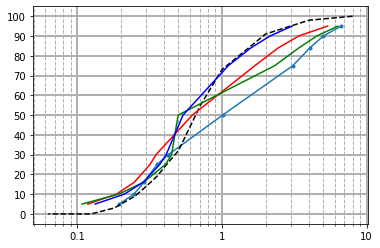

In [12]:
test = [0.118054645, 0.186310365, 0.247670135, 0.317578539, 0.350177529, 0.624333745, 1.688153862, 2.448495328, 3.390587561,5.361761284]
test2 = [0.107766565, 0.193308373, 0.28680506, 0.406366081, 0.448098974, 0.497635721, 2.314262063, 3.401015035, 4.515538293, 6.319018176]
test3 = [0.132774278, 0.211336978, 0.284868737, 0.37110029,	0.411149174, 0.537626271, 1.10490955, 1.584430602, 2.147100804, 3.049223151]
plt.plot(pd_T, percentiles, marker='.')
plt.plot(sieve_open, sieve_data_1, ls='--', color='black')
plt.plot(test, percentiles, color='red')
plt.plot(test2, percentiles, color='green')
plt.plot(test3, percentiles, color='blue')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()


In [43]:
data = pd.read_csv('/home/casper/Documents/Python/pyDGS GUI/Output data/08_07_22/Percentile_og/Percentiles_Location_7.csv')
data = np.array(data)
per = np.array([0.05, 0.1, 0.16, 0.25, 0.3, 0.5, 0.75, 0.84, 0.9, 0.95])

List = []
for i in range(len(data)):
    for j in range(1,11):
        if data[i,j] < 1:
            x = (data[i,j])**(-0.47) * per[j-1]
        else:
            x = (data[i,j])**(1) * per[j-1]
        List.append(x)

# print(np.shape(List))
List = np.reshape(List, (3,10))

for i in range(10):
    print(List[2,i])

0.11985304245808731
0.19201531415582643
0.2616238006792422
0.34640486381397767
0.3864391063214103
0.5101544956826759
1.242573006928977
1.7917575702619526
2.4449087168822916
3.393555335487067


[0.36193987 0.4973177  0.61506594 0.83101486 0.98917795 8.
 8.         8.         8.         8.        ]


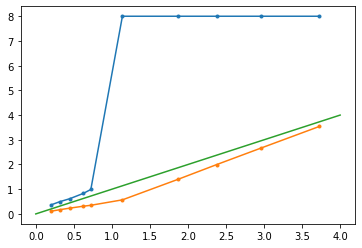

In [7]:
sieve_open = [0.063, 0.125, 0.18, 0.25, 0.3, 0.355, 0.425, 0.5, 0.71, 1, 2, 4, 8]
sieve_data_1 = [0, 0, 0.03, 0.09, 0.14, 0.19, 0.26, 0.32, 0.55, 0.73, 0.91, 0.98, 1]

percentiles = [5, 10, 16, 25, 30, 50, 75, 84, 90, 95] 

test = np.interp([0.196939872, 0.317854159, 0.446024601, 0.625112673, 0.723282864, 1.138194095, 1.874047957, 2.378131005, 2.954395884, 3.727846922], sieve_data_1, sieve_open)
print(test)
dried_1 = [0.196939872, 0.317854159, 0.446024601, 0.625112673, 0.723282864, 1.138194095, 1.874047957, 2.378131005, 2.954395884, 3.727846922]
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_data_1 = [100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]

cor = [0.107308269, 0.171377139, 0.233841367, 0.311773793, 0.349338469, 0.569097048, 1.405535967, 1.997630044, 2.658956296, 3.541454576]

plt.plot(dried_1, test, marker='.')

plt.plot(dried_1, cor, marker='.')
plt.plot(np.arange(0,5,1),np.arange(0,5,1) )
# #plt.plot(sieve_open, sieve_data_1, ls='--', color='black')
# plt.plot(test, percentiles, color='red')
# plt.plot(sieve_open, sieve_data_1, color='blue')

# plt.xscale("log")
# plt.grid(which='major', linewidth=2, linestyle='-')
# plt.grid(which='minor', linewidth=1, linestyle='--')
# plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
# plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()


[0.063 0.063 0.063 0.063 0.063 0.063 0.063 0.063 0.063 0.063]


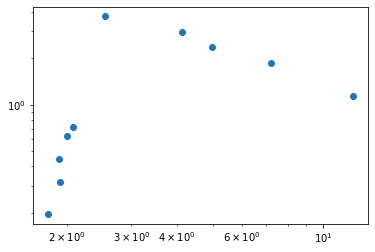

In [5]:
sieve = [0.20333333, 0.26, 0.322, 0.415, 0.475, 0.66434783, 1.11111111, 1.61111111, 1.94444444, 3.14285714]
og = [0.196939872, 0.317854159, 0.446024601, 0.625112673, 0.723282864, 1.138194095, 1.874047957, 2.378131005, 2.954395884, 3.727846922]
sieve = np.array(sieve)

perc = [0.05, 0.1, 0.16, 0.25, 0.3, 0.5, 0.75, 0.84, 0.9, 0.95]


test = np.interp([0.196939872, 0.317854159, 0.446024601, 0.625112673, 0.723282864, 1.138194095, 1.874047957, 2.378131005, 2.954395884, 3.727846922], sieve_data_1, sieve_open)
print(test)
test = [0.36193987, 0.4973177,  0.61506594, 0.83101486, 0.98917795, 8., 8., 8., 8., 8.]
test = np.array(test)

plt.scatter(test/sieve, og)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [6]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 0.1), np.maximum(nx,ny)/(width*resolution / 20), 1),  'morl', .5) #cmor10-1.9
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_3 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_3-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_3, np.mean(M), srt/2)
p = np.hstack([p])
scales_3 = np.hstack([scales_3])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_3 = (p*scales_3**x) / np.sum(p*scales_3**x) #volume-by-weight proportion

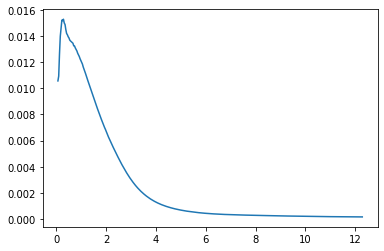

In [49]:
plt.plot(scales_3*resolution, r_v_3); plt.show()

In [148]:
a = scales_3*resolution

S_0 = scipy.integrate.simpson(r_v_3[np.where((a<0.063))]) * 100
S_63 = scipy.integrate.simpson(r_v_3[np.where((a>0.063)&(a<0.125))]) * 100
S_125 = scipy.integrate.simpson(r_v_3[np.where((a>0.125)&(a<0.180))]) * 100
S_180 = scipy.integrate.simpson(r_v_3[np.where((a>0.180)&(a<0.250))]) * 100
S_250 = scipy.integrate.simpson(r_v_3[np.where((a>0.250)&(a<0.300))]) * 100
S_300 = scipy.integrate.simpson(r_v_3[np.where((a>0.300)&(a<0.355))]) * 100
S_355 = scipy.integrate.simpson(r_v_3[np.where((a>0.355)&(a<0.425))]) * 100
S_425 = scipy.integrate.simpson(r_v_3[np.where((a>0.425)&(a<0.500))]) * 100
S_500 = scipy.integrate.simpson(r_v_3[np.where((a>0.500)&(a<0.710))]) * 100
S_710 = scipy.integrate.simpson(r_v_3[np.where((a>0.710)&(a<1))]) * 100
S_1000 = scipy.integrate.simpson(r_v_3[np.where((a>1)&(a<2))]) * 100
S_2000 = scipy.integrate.simpson(r_v_3[np.where((a>2)&(a<4))]) * 100
S_4000 = scipy.integrate.simpson(r_v_3[np.where((a>4)&(a<8))]) * 100
S_8000 = scipy.integrate.simpson(r_v_3[np.where((a>8))]) * 100

print(S_0)
print(S_63)
print(S_125)
print(S_180)
print(S_250)
print(S_300)
print(S_355)
print(S_425)
print(S_500)
print(S_710)
print(S_1000)
print(S_2000)
print(S_4000)
print(S_8000)


0.0
0.0
1.3329136643581874
1.4921127142107609
1.5257456182994085
1.4967113818369417
1.436845428272822
1.4043545371862558
8.151591549000782
10.168611642033039
28.755976756727954
20.44496188808517
6.413428692174103
2.485218884739063


In [144]:

S_63 = scipy.integrate.simpson(r_v_3[1:2])
S_125 = scipy.integrate.simpson(r_v_3[2:4])
S_180 = scipy.integrate.simpson(r_v_3[4:6])
S_250 = scipy.integrate.simpson(r_v_3[6:8])
S_300 = scipy.integrate.simpson(r_v_3[8:10])
S_355 = scipy.integrate.simpson(r_v_3[10:12])
S_425 = scipy.integrate.simpson(r_v_3[12:14])
S_500 = scipy.integrate.simpson(r_v_3[14:21])
S_710 = scipy.integrate.simpson(r_v_3[21:30])
S_1000 = scipy.integrate.simpson(r_v_3[30:62])
S_2000 = scipy.integrate.simpson(r_v_3[62:125])
S_4000 = scipy.integrate.simpson(r_v_3[125:251])
S_8000 = scipy.integrate.simpson(r_v_3[251:386])

print(S_63, S_125, S_180, S_250, S_300, S_355, S_425, S_500, S_710, S_1000, S_2000,S_4000, S_8000)


0.0 0.013329136643581874 0.01492112714210761 0.015257456182994084 0.014967113818369418 0.01436845428272822 0.014043545371862557 0.08151591549000782 0.10168611642033039 0.2875597675672795 0.20444961888085172 0.06413428692174103 0.02485218884739063


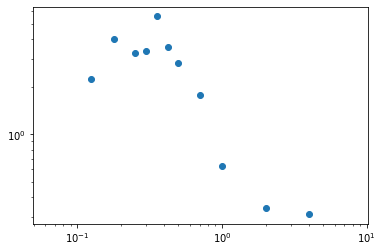

In [109]:
sieve_open = np.array([0.063, 0.125, 0.18, 0.25, 0.3, 0.355, 0.425, 0.5, 0.71, 1, 2, 4, 8])
dgs_percentage = np.array([2.152388708, 2.665827329, 2.984225428, 3.051491237, 2.993422764, 2.873690857, 2.808709074, 	
                           9.508018248, 11.43891901, 29.6914816, 20.8377726, 6.48896004, 2.505093103])
dgs_percentage = np.array([1.076194354, 1.332913664, 1.492112714, 1.525745618, 1.496711382, 1.436845428, 1.404354537, 
                           8.150703051,	10.16892862, 28.75577409, 20.44620904, 6.413687346,	2.485296245])
sieve_percentage = np.array([0, 3, 6, 5, 5, 8, 5, 23, 18, 18, 7, 2, 0])


plt.scatter(sieve_open, (sieve_percentage/dgs_percentage))
plt.xscale("log")
plt.yscale("log")
plt.show()

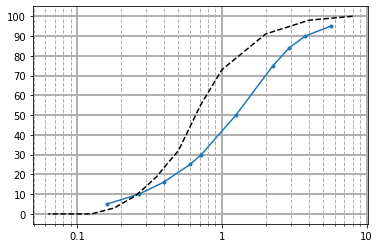

In [7]:
r_v_T = r_v_3

scales_T = scales_3

pd_T = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_T))), np.hstack((0,scales_T)) ) * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_data_1 = [100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]

percentiles = [5, 10, 16, 25, 30, 50, 75, 84, 90, 95] 


plt.plot(pd_T, percentiles, marker='.')
plt.plot(sieve_open, sieve_data_1, ls='--', color='black')


plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [74]:
print(pd_T)

[0.16074682 0.26608943 0.39470153 0.60105259 0.71960049 1.24866749
 2.25087182 2.91487539 3.76731951 5.64395925]


[100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]
[0.5617876  0.52280464 0.5235211  0.49938939 0.48019671 0.08304348
 0.13888889 0.20138889 0.24305556 0.39285714]
[0.16074682, 0.26608943, 0.39470153, 0.60105259, 0.71960049, 1.24866749, 2.25087182, 2.91487539, 3.76731951, 5.64395925]


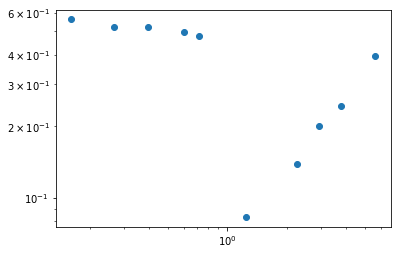

In [8]:
sieve = [0.20333333, 0.26, 0.322, 0.415, 0.475, 0.66434783, 1.11111111, 1.61111111, 1.94444444, 3.14285714]
og = [0.196939872, 0.317854159, 0.446024601, 0.625112673, 0.723282864, 1.138194095, 1.874047957, 2.378131005, 2.954395884, 3.727846922]
og = [0.16074682, 0.26608943, 0.39470153, 0.60105259, 0.71960049, 1.24866749, 2.25087182, 2.91487539, 3.76731951, 5.64395925]
sieve = np.array(sieve)

perc = [0.05, 0.1, 0.16, 0.25, 0.3, 0.5, 0.75, 0.84, 0.9, 0.95]

test = np.interp([0.196939872, 0.317854159, 0.446024601, 0.625112673, 0.723282864, 1.138194095, 1.874047957, 2.378131005, 2.954395884, 3.727846922], sieve_data_1, sieve_open)
print(sieve_data_1)
test = [0.36193987, 0.4973177,  0.61506594, 0.83101486, 0.98917795, 8., 8., 8., 8., 8.]
test = np.array(test)

print((sieve/test))
print(og)
plt.scatter(og, (sieve/test))
plt.xscale("log")
plt.yscale("log")
plt.show()

In [65]:
data = pd.read_csv('/home/casper/Documents/Python/pyDGS GUI/pyDGS-GUI/Output data/08_07_22/Percentile_og/Percentiles_Location_1.csv')
data = np.array(data) #, dtype='float64')
data = np.array(data[0:15, 1:11], dtype='float64')
print(sieve_data_1)
print(sieve_open)
for i in range(len(data)):
    test =  np.interp(data[i,:], sieve_data_1, sieve_open)


[100, 98, 91, 73, 55, 32, 26, 19, 14, 9, 3, 0, 0]
[8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/tmp/ipykernel_6161/1097471449.py:33: RuntimeWarning: invalid value encountered in true_divide
  plt.scatter(gs, (sieve/loc9))


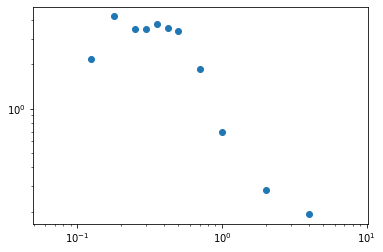

In [166]:
loc1 = np.array([0,	0,	0,	0,	0,	0,	0,	0,	5.05609553,	7.127824084, 25.74586521, 24.60193485, 10.2900552, 4.099655655])
loc2 = np.array([0, 0, 1.143922977, 0, 1.402729424, 0, 1.412284294, 1.39944825, 5.359249011, 8.704286954, 23.60935649, 25.50076579, 12.16763407, 4.854059926])
loc3 = np.array([0, 0.632637115, 0.754589873, 1.652214745, 0.842613787, 0.842965001, 1.67727332, 1.662260345, 5.630815981, 7.622537422, 23.84003035, 26.63272798, 13.39170445, 5.996307844])
loc4 = np.array([0, 1.031853462, 0.566512161, 1.757856922, 0.600552954, 1.213867131, 1.220371648, 1.225888632, 6.145019212, 7.181018576, 24.0572041,	28.12561007, 13.9673545, 6.22103677])
loc5 = np.array([0, 1.029136338, 1.143560975, 2.01730226, 1.25877918, 1.283878954, 1.7292024, 2.165660589, 6.342407681, 8.398424482, 24.50587532, 26.64084804, 13.44683689, 5.481171181])
loc6 = np.array([0, 0, 1.332819397, 1.492063141, 1.525883169, 1.496859282, 1.436979632, 1.404507705, 8.15237518, 10.16905384, 28.75501092, 20.44324711, 6.413615366, 2.485251528])
loc7 = np.array([0, 0.655773463,	1.712051202, 1.994495148, 1.042964069, 1.045650298, 2.078359434, 3.055064037, 7.828795942, 10.8394842, 28.12645805, 21.55880828, 6.949390764, 2.963717237])
loc8 = np.array([0, 0, 1.248216539, 1.434530121, 0, 0, 1.496477524, 1.461163598, 6.897625637, 8.892367791, 25.29700006, 24.20018812, 10.33533055, 3.820063202])
loc9 = np.array([0, 1.258584415, 1.372329302, 1.415329677, 1.426332494, 1.434454807, 2.135566595, 1.405736392, 6.808659751, 9.676059345, 26.04054034, 25.1420159, 10.39898001, 3.923398487])
loc11 = np.array([0, 0, 0, 1.51964104, 0, 0, 1.701286962, 0, 6.503960745, 8.948466971, 24.53937615, 24.96543279, 11.05942177, 4.093518449])
loc12 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 3.430340111, 3.639512824, 25.68943825, 26.81945738, 12.16137925, 4.227444179])
loc13 = np.array([0, 0, 0, 1.51964104, 0, 0, 1.701286962, 0, 6.503960745, 8.948466971, 24.53937615, 24.96543279, 11.05942177, 4.093518449])
loc14 = np.array([0, 0.801713074, 0.918123828, 1.931782494, 0.955985587, 0.95579608, 1.88463133, 1.841926233, 6.194396267, 8.285525729, 25.38088512, 25.40851797, 11.1492348, 4.30602957])
loc15 = np.array([0, 1.255947742, 1.352592903, 2.043040507, 0.675576513, 1.338473796, 1.975758125, 1.941037622, 6.961843659, 8.38708148, 25.96611943, 25.59280396, 11.24091027, 4.044019302])
locdried = np.array([0, 0.772380844, 0.441021017, 1.504127394, 0.543986747, 1.149935709, 1.201539811, 1.237909225, 5.700507221, 8.011098146, 24.21869424, 28.42672566, 14.51357936, 6.0725475])


sieve = np.array([0, 0, 3, 6, 5, 5, 8, 5, 23, 18, 18, 7, 2, 0])

gs = np.array([0, 0.063, 0.125, 0.18, 0.25, 0.3, 0.355, 0.425, 0.5, 0.71, 1, 2, 4, 8])

# a,b = np.polyfit(gs, (sieve/loc1), 1)
# print(a,b)
# plt.plot(gs, a*gs+b)
# plt.scatter(gs, (sieve/loc1))
# plt.scatter(gs, (sieve/loc2))
# plt.scatter(gs, (sieve/loc3))
# plt.scatter(gs, (sieve/loc4))
# plt.scatter(gs, (sieve/loc5))
# plt.scatter(gs, (sieve/loc6))
# plt.scatter(gs, (sieve/loc7))
# plt.scatter(gs, (sieve/loc8))
plt.scatter(gs, (sieve/loc9))
# plt.scatter(gs, (sieve/loc11))
# plt.scatter(gs, (sieve/loc12))
# plt.scatter(gs, (sieve/loc13))
# plt.scatter(gs, (sieve/loc14))
# plt.scatter(gs, (sieve/loc15))
# plt.scatter(gs, (sieve/locdried))
plt.xscale("log")
plt.yscale("log")
plt.show()

-0.37663369607087277 2.4188910481597996


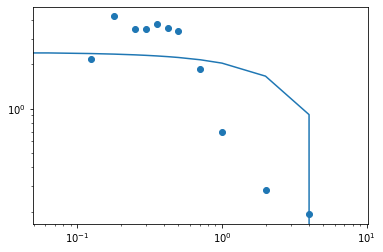

In [172]:
t = [0, 0, 2.186064231, 4.239294983, 3.505494, 3.485644842, 3.746078449, 3.556854634, 3.378051018, 1.860261431, 0.691229896, 0.278418406, 0.192326555, 0]

a,b = np.polyfit(gs, t, 1)
print(a,b)
plt.plot(gs, a*gs+b)

plt.scatter(gs, t)
plt.xscale("log")
plt.yscale("log")
plt.show()